In [1]:
import numpy as np

# Neural Networks Learning

把week4中逻辑回归单个输出的情况拓展到多个输出。此时可以从逻辑回归的二分类拓展到多分类。
- 二分类：0，1
- K类分类：0-n
  
对于每一行特征，都会给出个预测，基本上可以利用循环，对每一行特征都预测个不同结果，然后利用循环在个预测中选择可能性最高的一个，将其与中的实际数据进行比较。

In [2]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    """
    Draw a neural network cartoon using matplotlib.

    :param ax: matplotlib.axes.Axes
        The axes on which to plot the cartoon (get e.g. by plt.gca())
    :param left: float
        The center of the leftmost node(s) will be placed here
    :param right: float
        The center of the rightmost node(s) will be placed here
    :param bottom: float
        The center of the bottommost node(s) will be placed here
    :param top: float
        The center of the topmost node(s) will be placed here
    :param layer_sizes: list of int
        List containing the number of nodes in each layer
    """
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4., 
                                color='orange' if n > 0 else 'lightblue', ec='k', zorder=4)
            ax.add_artist(circle)

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left], 
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='black')
                ax.add_artist(line)

    # Layer Labels and Activation Labels
    for n in range(len(layer_sizes)):
        ax.annotate(f"Layer {n+1}", (n*h_spacing + left, bottom - 0.1), xytext=(0, -12), 
                    textcoords='offset points', ha='center', va='center', fontsize=12)
        ax.annotate(rf'$a^{{({n+1})}}$', (n*h_spacing + left, top + 0.05), xytext=(-20, 10), 
                    textcoords='offset points', ha='center', va='center', fontsize=14)



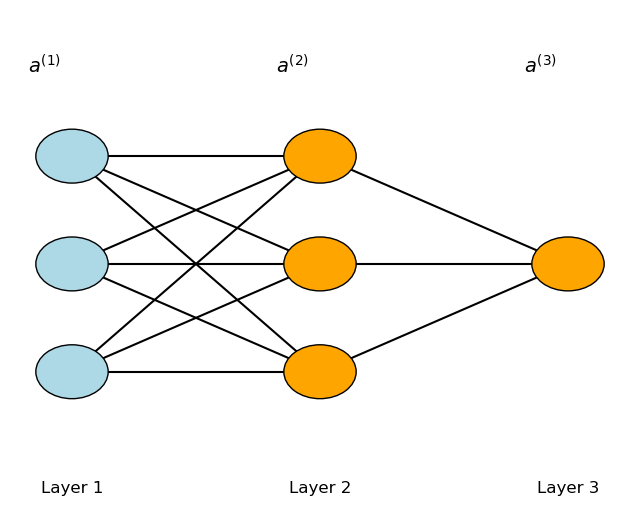

In [3]:
# 二元分类，只有一个output
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.axis('off')
layer_sizes = [3,3,1]  # Example sizes for layers
draw_neural_net(ax, .1, .9, .1, .8, layer_sizes)
plt.show()

回顾，逻辑函数的代价函数是：

$J(\Theta) = -\frac{1}{m} \left[ \sum_{i=1}^{m} y^{(i)} \log h_\Theta(x^{(i)}) + (1 - y^{(i)}) \log \left(1 - h_\Theta(x^{(i)})\right) \right] + \frac{\lambda}{2m} \sum_{j=1}^{n} \Theta_j^2$

拓展到多个输出的情况：

$$
J(\Theta) = -\frac{1}{m} \left[ \sum_{i=1}^{m} \sum_{k=1}^{K} y_k^{(i)} \log ( h_\Theta(x^{(i)})_k ) + \left( 1 - y_k^{(i)} \right) \log \left( 1 - h_\Theta(x^{(i)})_k \right) \right] + \frac{\lambda}{2m} \sum_{l=1}^{L-1} \sum_{i=1}^{s_l} \sum_{j=1}^{s_{l+1}} \left( \Theta_{j,i}^{(l)} \right)^2
$$

- 公式左侧的部分表示多分类模型中的交叉熵损失；
- 公式右侧的正则化项用于防止过拟合；
- 正则化的那一项只是排除了每一层$\theta _0$后，每一层的$\theta$矩阵的和。

# 反向传播算法（Backpropagation Algorithm ）

为了计算代价函数的偏导数$\frac{\partial{J(\Theta)}}{\partial{\Theta _{ij}} ^{(i)}}$，我们需要采用一种反向传播算法，也就是首先计算最后一层的误差，然后再一层一层反向求出各层的误差，直到倒数第二层。

在神经网络中，**误差项 $\delta$** 用来表示在某一层上的预测误差。我们从输出层开始计算误差项，然后逐层传播误差以更新网络的权重。具体步骤如下：

- 我们用 $\delta$ 来表示误差。对于输出层（假设为第 4 层），误差项定义为：
  $$\delta^{(4)} = a^{(4)} - y$$
  其中，$a^{(4)}$ 是输出层的激活值，而 $y$ 是期望值或真实标签。这个表达式表示输出层的预测与真实值之间的差距。

- 接下来，我们利用这个误差来计算前一层（即第 3 层）的误差项：
  $$\delta^{(3)} = (\Theta^{(3)})^T \delta^{(4)} \odot g'(z^{(3)})$$
  其中，$g'(z^{(3)})$ 是 $S$ 形函数的导数，计算方式为：
  $$g'(z^{(3)}) = a^{(3)} \odot (1 - a^{(3)})$$
  这里 $\odot$ 表示逐元素相乘操作，而 $(\Theta^{(3)})^T \delta^{(4)}$ 是权重矩阵与误差项的转置乘积（权重导致的误差的和），这有助于将误差从输出层逆向传播到隐藏层。

- 下一步是继续计算第 2 层的误差项：
  $$\delta^{(2)} = (\Theta^{(2)})^T \delta^{(3)} \odot g'(z^{(2)})$$
  由于第一层是输入层，没有计算误差项的必要，因为它简单地将输入传递给下一级。

- 在计算完所有层的误差项后，我们可以更新网络的权重。假设正则化项 $\lambda = 0$（即我们不进行正则化处理），简化梯度计算为：
  $$\frac{\partial}{\partial \Theta_{ij}^{(l)}} J(\Theta) = a_j^{(l)} \delta_i^{(l+1)}$$

  - $l$是层数


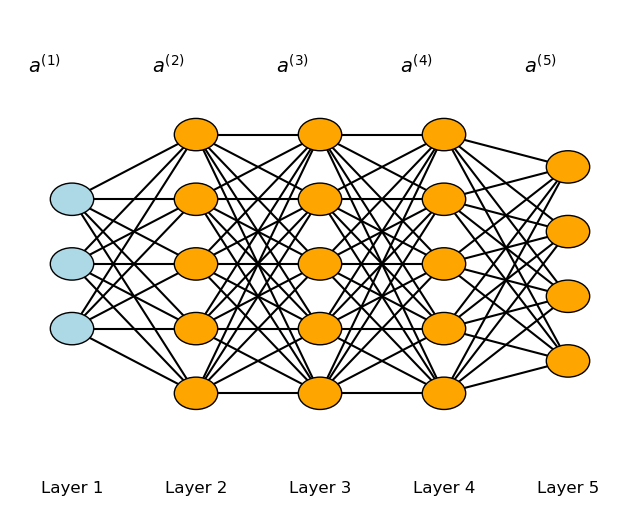

In [4]:
# k类分类，有多个output
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.axis('off')

layer_sizes = [3, 5, 5, 5, 4]
draw_neural_net(ax, .1, .9, .1, .8, layer_sizes)

plt.show()

- 考虑正则化处理，并且我们的训练集是一个特征矩阵而非向量；
- 在上面的特殊情况中，我们需要计算每一层的误差单元来计算代价函数的偏导数。
---
在更为一般的情况中，我们同样需要计算每一层的误差单元，但是我们需要为整个训练集计算误差单元，此时的误差单元也是一个矩阵，我们用$\Delta _{ij} ^ l$来表示这个误差矩阵。第$l$层的第$i$个激活单元受到第$j$个参数影响而导致的误差。
  - 首先用正向传播方法计算出每一层的激活单元，利用训练集的结果与神经网络预测的结果求出最后一层的误差。
$$
\delta^{(L)} = a^{(L)} - y^{(i)}
$$

  - 然后利用该误差运用反向传播法计算出直至第二层的所有误差：
  
$$
\Delta_{ij}^{(l)} := \Delta_{ij}^{(l)} + a_j^{(l)} \delta_i^{(l+1)}
$$

在求出了 $\Delta_{ij}^{(l)}$ 之后，可以计算代价函数的偏导数，方法如下：

$$
D_{ij}^{(l)} := \frac{1}{m} \Delta_{ij}^{(l)} + \lambda \Theta_{ij}^{(l)} \quad \text{if } j \neq 0
$$

$$
D_{ij}^{(l)} := \frac{1}{m} \Delta_{ij}^{(l)} \quad \text{if } j = 0
$$


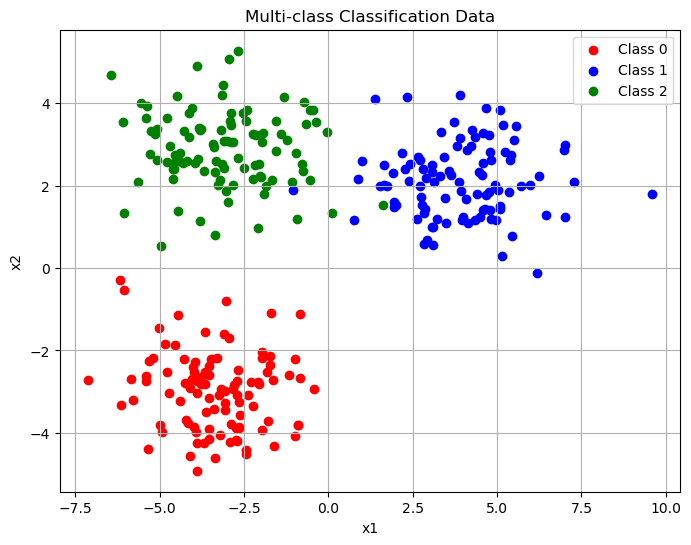

In [5]:
# 先造点数据
import matplotlib.pyplot as plt

np.random.seed(42)

num_samples = 100  # 每个类别的样本数量
num_classes = 3  # 类别数量

# 定义类别中心，用于生成数据
centers = [
    (-3.2, -3),
    (3.8, 2),
    (-3, 3)
]

# 生成数据
data = []
labels = []

for i, center in enumerate(centers):
    x1 = np.random.normal(center[0], 1.5, num_samples)
    x2 = np.random.normal(center[1], 1, num_samples)
    for j in range(num_samples):
        data.append([x1[j], x2[j]])
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']

for i in range(num_classes):
    plt.scatter(data[labels == i][:, 0], data[labels == i][:, 1],
                 color=colors[i], label=f'Class {i}')

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Multi-class Classification Data")
plt.legend()
plt.grid(True)
plt.show()


Text(0.5, 1.0, 'Unknown Samples')

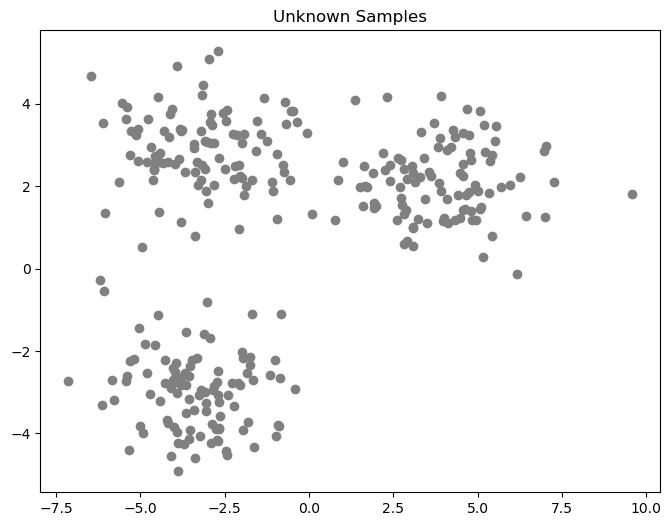

In [6]:
# 先把造出的数据打乱，目标是在乱序数据集中对每个点分类
indices = np.arange(len(data))
data = data[np.random.shuffle(indices)][0]
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], color='gray')
plt.title('Unknown Samples')

定义激活函数

$g(z) = \frac{1}{1+e^{-z}}$

$\frac{\partial g(z)}{\partial z} = \frac{e^{-z}}{(1+e^{-z})^{2}} = \frac{1}{1+e^{z}} \frac{e^{-z}}{1+e^{-z}} = g(z) (1-g(z))$


In [7]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

# 先看看sklearn的解

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.94      1.00      0.97        16
           2       1.00      0.95      0.98        22

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



In [9]:
predictions

array([2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0, 1, 2, 2, 2, 1, 1, 0, 1,
       2, 2, 1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 1, 2, 1, 1, 2, 0, 2, 1, 0, 0, 1, 0])

# 使用反向传播法求解

In [10]:
# 处理X和y为标准数据
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

X = standardize(data)

def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

y = one_hot(labels, num_classes=3) 

In [11]:
X

array([[-4.35970310e-01, -1.84537869e+00],
       [-6.94297019e-01, -1.48450366e+00],
       [-3.74549776e-01, -1.45623126e+00],
       [-1.84368395e-02, -1.62295538e+00],
       [-7.33307333e-01, -1.39041096e+00],
       [-7.33300654e-01, -1.18531331e+00],
       [ 4.41993436e-03, -6.47611643e-01],
       [-3.25833730e-01, -1.26856351e+00],
       [-8.29042396e-01, -1.23846201e+00],
       [-4.17318941e-01, -1.35890647e+00],
       [-8.26578367e-01, -2.02800663e+00],
       [-8.27518977e-01, -1.34151728e+00],
       [-5.39610386e-01, -1.31004751e+00],
       [-1.41642235e+00, -4.38262241e-01],
       [-1.33979134e+00, -1.40168471e+00],
       [-8.66801337e-01, -1.22250041e+00],
       [-1.05009487e+00, -1.34449138e+00],
       [-5.10202834e-01, -1.75588139e+00],
       [-1.00745648e+00, -9.17295281e-01],
       [-1.21261131e+00, -1.05910563e+00],
       [-4.17810449e-02, -1.04492099e+00],
       [-7.29899309e-01, -1.66181373e+00],
       [-6.10574965e-01, -8.22980591e-01],
       [-1.

In [12]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

定义神经网络结构：
- 输入层：2个神经元：x1， x2
- 隐藏层：4个神经元：用sigmod函数激活
- 输出层：3个神经元：分类目标为3类

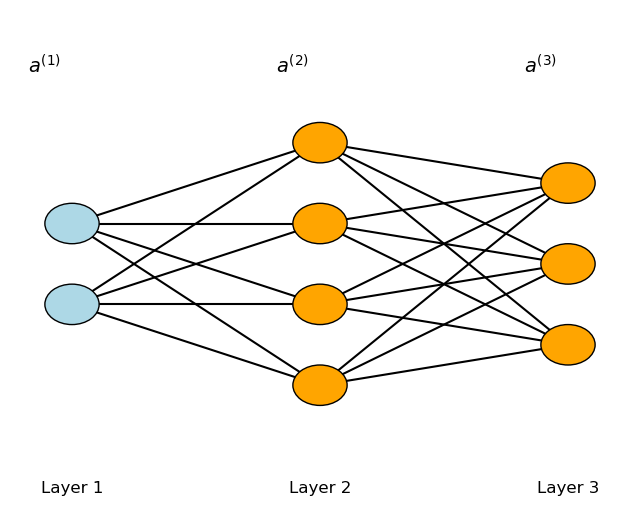

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()
ax.axis('off')

layer_sizes = [2, 4, 3]
draw_neural_net(ax, .1, .9, .1, .8, layer_sizes)

plt.show()

In [14]:
# 定义网络
np.random.seed(42)

input_size = 2
hidden_size = 4
output_size = 3
learning_rate = 0.1
epochs = 1000

# 随机初始化（小随机值）
W_1 = np.random.randn(input_size, hidden_size) * 0.1  # 第一层权重，randn 生成正态分布，适合权重初始化；rand 是均匀分布，效果通常不如正态分布。
b_1 = np.zeros(hidden_size)  # 第一层截距项，也成为偏置bias
W_2 = np.random.randn(hidden_size, output_size) * 0.1  # 第二层权重， 0.1是一个经验性缩放因子，避免初始激活值过大
b_2 = np.zeros(output_size)

In [15]:
# 用于输出层，主要从多分类的概率解释考虑，如果只做lable标注可以不要这个，但是基本上都还是会在输出层做这一步
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # 防止数值溢出
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

In [16]:
# forward
def forward(X, W_1, b_1, W_2, b_2):
    # 隐藏层
    Z_1 = np.dot(X, W_1) + b_1
    A_1 = sigmoid(Z_1)
    
    # 输出层
    Z_2 = np.dot(A_1, W_2) + b_2
    A_2 = softmax(Z_2)
    return Z_1, A_1, Z_2, A_2

def backward(X, y, Z_1, A_1, A_2, W_1, W_2, b_1, b_2, learning_rate):
    m = X.shape[0]  # 样本数量
    
    # 输出层误差（交叉熵损失 + Softmax 的梯度）
    dZ_2 = A_2 - y
    dW_2 = np.dot(A_1.T, dZ_2) / m
    db_2 = np.sum(dZ_2, axis=0) / m

    
    # 隐藏层误差
    dZ_1 = np.dot(dZ_2, W_2.T) * sigmoid_derivative(Z_1)  # 链式法则，代价函数L对Z_1的导数等于L对A_1的导数乘以A_1对Z_1的导数
    dW_1 = np.dot(X.T, dZ_1) / m
    db_1 = np.sum(dZ_1, axis=0) / m
    
    # 更新权重 w - learning_rate * 梯度（L对w和b的导数）
    W_1 -= learning_rate * dW_1
    b_1 -= learning_rate * db_1
    W_2 -= learning_rate * dW_2
    b_2 -= learning_rate * db_2
    
    return W_1, b_1, W_2, b_2

def compute_loss(y, y_pred):
    return -np.mean(y * np.log(y_pred + 1e-10))  # 加 1e-10 防止 log(0)

def predict(X, W_1, b_1, W_2, b_2):
    _, _, _, A_2 = forward(X, W_1, b_1, W_2, b_2)
    return np.argmax(A_2, axis=1)


说明一下：

- 定义代价函数（损失函数）：
  
$L = - \Sigma_i y_i log(p_i)$

$p_i = softmax(z_i) = \frac{e^{z_i}}{\Sigma e^{z_j}}$

In [17]:
loss_history = []

for epoch in range(epochs):
    # 前向传播
    Z_1, A_1, Z_2, A_2 = forward(X, W_1, b_1, W_2, b_2)
    
    # 计算损失
    loss = compute_loss(y, A_2)
    loss_history.append(loss)
    
    # 反向传播
    W_1, b_1, W_2, b_2 = backward(X, y, Z_1, A_1, A_2, W_1, W_2, b_1, b_2, learning_rate)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")


Epoch 0, Loss: 0.3672
Epoch 100, Loss: 0.3524
Epoch 200, Loss: 0.2852
Epoch 300, Loss: 0.1971
Epoch 400, Loss: 0.1288
Epoch 500, Loss: 0.0840
Epoch 600, Loss: 0.0594
Epoch 700, Loss: 0.0456
Epoch 800, Loss: 0.0374
Epoch 900, Loss: 0.0320


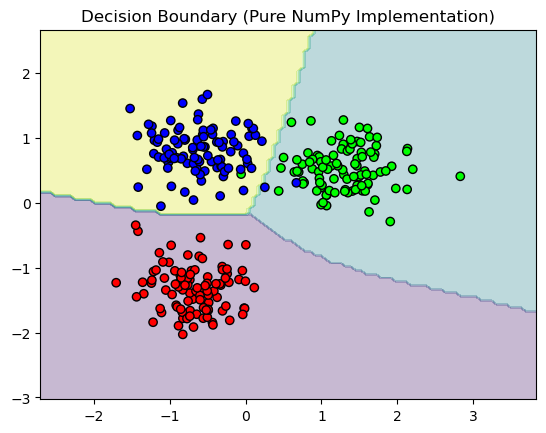

In [18]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), 
                        np.linspace(y_min, y_max, 100))

# 预测网格点类别
Z = predict(np.c_[xx.ravel(), yy.ravel()], W_1, b_1, W_2, b_2)
Z = Z.reshape(xx.shape)

# 绘制
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
plt.title("Decision Boundary (Pure NumPy Implementation)")
plt.show()

## 神经网络反向传播中的 `dZ_1` 和 `dZ_2` 具体例子说明

假设一个简单的网络结构：
- **输入层**：2个神经元  
- **隐藏层**：3个神经元（Sigmoid激活）  
- **输出层**：2个神经元（Softmax激活）  

### **前向传播**

1. **隐藏层线性输出**：
   $
   Z_1 = X \cdot W_1 + b_1 \quad \text{(形状：} m \times 3\text{)}
   $
2. **隐藏层激活输出**：
   $
   A_1 = \text{Sigmoid}(Z_1) \quad \text{(形状：} m \times 3\text{)}
   $
3. **输出层线性输出**：
   $
   Z_2 = A_1 \cdot W_2 + b_2 \quad \text{(形状：} m \times 2\text{)}
   $
4. **输出层概率**：
   $
   A_2 = \text{Softmax}(Z_2) \quad \text{(形状：} m \times 2\text{)}
   $

---

### **反向传播**

1. **计算输出层梯度 `dZ_2`**：
   $
   dZ_2 = A_2 - y\_true \quad \text{(形状：} m \times 2\text{)}
   $
   - 直接表示预测概率与真实标签的误差。

2. **计算隐藏层梯度 `dZ_1`**：
   $
   dZ_1 = (dZ_2 \cdot W_2^T) * \text{Sigmoid}'(Z_1) \quad \text{(形状：} m \times 3\text{)}
   $
   - **关键步骤**：
     - 通过权重 $ W_2^T $ 将误差从输出层回传到隐藏层（形状匹配：$ (m \times 2) \cdot (2 \times 3) = m \times 3 $）。
     - 乘以Sigmoid导数 $ \sigma'(Z_1) $（逐元素乘法）。

3. **更新权重和偏置**：
   - **输出层参数梯度**：
     $
     dW_2 = \frac{A_1^T \cdot dZ_2}{m}, \quad db_2 = \frac{\sum dZ_2}{m}
     $
   - **隐藏层参数梯度**：
     $
     dW_1 = \frac{X^T \cdot dZ_1}{m}, \quad db_1 = \frac{\sum dZ_1}{m}
     $

---

### **关键公式总结**

| 步骤         | 公式                                                                 | 说明                          |
|--------------|----------------------------------------------------------------------|-----------------------------|
| 输出层梯度   | $ dZ_2 = A_2 - y\_true $                                             | 直接误差信号                  |
| 隐藏层梯度   | $ dZ_1 = (dZ_2 \cdot W_2^T) * \sigma'(Z_1) $                           | 误差回传 + 激活函数导数        |
| 更新 $ W_2 $ | $ dW_2 = \frac{A_1^T \cdot dZ_2}{m} $                                 | 隐藏层激活值的转置与误差的乘积  |
| 更新 $ b_2 $ | $ db_2 = \frac{\sum dZ_2}{m} $                                       | 误差的均值                    |
| 更新 $ W_1 $ | $ dW_1 = \frac{X^T \cdot dZ_1}{m} $                                  | 输入数据的转置与隐藏层误差的乘积|
| 更新 $ b_1 $ | $ db_1 = \frac{\sum dZ_1}{m} $                                       | 隐藏层误差的均值               |

---

# 梯度检验

有点像期权求某些参数偏导的有限差分法。

- 对梯度的估计采用的方法是在代价函数上沿着切线的方向选择离两个非常近的点然后计算两个点的平均值用以估计梯度;
- 即对于某个特定的$\theta$，我们计算出在$\theta - \epsilon$处和$\theta + \epsilon$的代价值（是一个非常小的值，通常选取 0.001），然后求两个代价的平均，用以估计在$\theta$处的代价值;

$$\frac{\partial}{\partial \theta_1} = \frac{J(\theta_1 + \epsilon, \theta_2, \theta_3, \ldots, \theta_n) - J(\theta_1 - \epsilon, \theta_2, \theta_3, \ldots, \theta_n)}{2\epsilon}$$

